In [1]:
import pandas as pd
import numpy as np
from trails.read_data import get_obs_state_dct
import re
from trails.cutpoints import cutpoints_ABC, cutpoints_AB
from trails.optimizer import post_prob
%load_ext rpy2.ipython

n_sites = 200000
# name = 'sim_45ILS_0.5sel'
# name = '../results/sim_45ILS_nosel'
name = '../results/sim_45ILS_0.5sel_deep'

In [2]:

def mutations(dir_name, i):
    """
    This function parses the SLiM output for a certain sample.
    """
    # Save the mutations
    with open(f'{dir_name}_{i}.log', 'r') as f:
        mut = False
        for line in f:
            if line == 'Mutations:\n':
                mutations = []
                mut = True
            elif line == 'Genomes:\n':
                break
            elif mut:
                mutations.append(line.strip('\n'))
    l = [m.split(' ')+[i] for m in mutations]
    return l

In [3]:
def slim_to_df(dir_name):
    # Run the function for all samples
    l_tot = []
    for i in ['1', '2', '3', '4']:
        l = mutations(dir_name, i)
        l_tot = l_tot + l

    # Make pandas data frame
    df = pd.DataFrame(l_tot, 
                       columns = ['mut_id_sample', 'id', 'type', 'pos', 'sel', 'dom', 'pop', 'time', 'prev', 'sam'])
    # Drop temporary mutation id
    df = df.drop(['mut_id_sample'], axis=1)
    # Calculate max time per position and sample, in case there are multiple mutations on the same position
    df['max'] = df.groupby(['pos', 'sam'])['time'].transform(max)
    # Only keep latest mutation
    df = df[df['time'] == df['max']]
    # Merge samples
    df = df.groupby(['id', 'pos', 'time'])['sam'].apply(lambda x: ''.join(x)).reset_index()
    # Get genotype
    df['sam2'] = [''.join(['1' if str(y) in x else '0' for y in range(1, 5)]) for x in df['sam']]
    # Change type
    df = df.astype({"id":"int", "pos":"int"})
    # Arrange values by time
    df = df.sort_values('time')
    return df

In [4]:
def genotype(site, sam2): 
    """
    This function samples a random nt for a mutation
    """
    nochange_lst = ['A', 'C', 'T', 'G']
    nochange_lst.remove(site.upper())
    geno1 = np.random.choice(nochange_lst, 1)[0]
    g_mut = ''.join([site if j == '0' else geno1 for j in sam2])
    return g_mut

In [5]:
def df_to_dfsim(df2, n_sites, seed):

    # Simulate random genome
    np.random.seed(seed); sim_genome = np.random.choice(['a', 'c', 't', 'g'], n_sites)

    # Save ancestral allele
    df2['geno'] = [sim_genome[i] for i in df2['pos']]
    # Change genotype according to mutational pattern
    np.random.seed(seed+1); df2['geno2'] = [genotype(variant[1]['geno'], variant[1]['sam2']) for variant in df2.iterrows()]
    # Calculate how many mutations per site
    df2['size'] = [list(df2['pos']).count(i) for i in df2['pos']]
    df2 = df2.sort_values(['pos', 'time'])

    return df2, sim_genome

In [6]:
def combine_sam2(x):
    """
    This function combines sam2 columns
    """
    l = []
    acc = 1
    for i in x:
        i = i.replace('1', str(acc))
        l.append(i)
        acc += 1
    res = '0000'
    for i in l:
        for j in range(len(i)):
            if i[j] != '0':
                list1 = list(res)
                list1[j] = i[j]
                res = ''.join(list1)
    return res

def combine_geno2(x):
    """
    This function combines geno2 columns
    """
    acc = 1
    for i in x:
        for j in i:
            if j in ['a', 'c', 't', 'g']:
                low = j
    res = low+low+low+low
    for i in x:
        for j in range(len(i)):
            if i[j] != low:
                list1 = list(res)
                list1[j] = i[j]
                res = ''.join(list1)
    return res.upper()

In [7]:
def clean_dfsim(df2, sim_genome):
    df3 = df2.groupby(['pos']).agg(
        {'id': 'max', 
         'time': 'max',
         'sam': 'max',
         'sam2': combine_sam2,
         'geno': 'max',
         'geno2': combine_geno2,
         'size': 'max'
        }).reset_index()

    # Get dictionary from data frame
    d = dict(zip(df3.pos, df3.geno2))
    # Get ancestral genotype
    sim_genome_upper = [i.upper()*4 for i in sim_genome]
    # Add mutations at the right location
    for i in list(d.keys()):
        sim_genome_upper[i] = d[i]
    lst_index = get_obs_state_dct()
    sim_genome_idx = [lst_index.index(i) for i in sim_genome_upper]
    return sim_genome_idx


In [8]:
def wrapper(dir_name, n_sites, seed):
    df = slim_to_df(dir_name)
    df2, sim_genome = df_to_dfsim(df, n_sites, seed)
    return clean_dfsim(df2, sim_genome)

In [9]:
sim_genome_idx = np.array(wrapper(name, n_sites, 1))
sim_genome_idx

array([ 85, 255,   0, ...,   2,   0, 255])

In [10]:
import msprime, tskit
ts = tskit.load(name+".trees")
ts = ts.simplify()
ts = ts.simplify(samples = [0, 2, 4, 6])

t = ts.first()
t_new = t.as_newick(include_branch_lengths=False)
t_new

'(n3,(n2,(n0,n1)));'

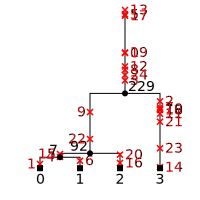

In [11]:
t.draw_svg()

In [12]:
# find_re = [sorted(re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0].split(',')) for t in ts.trees()]
# find_re_2 = [r != ['n0', 'n1'] for r in find_re]
# sum(find_re_2)/len(find_re_2)

## Second coalescent

In [13]:
ILS = 32

t_A = 200000/200
t_B = 200000/200
t_1 = max([t_A, t_B])
N_AB = 80000/200
t_2 = -N_AB*np.log(3/2*ILS/100)
t_C = t_1+t_2
N_ABC = 70000/200
t_3 = t_1*5
r = 0.5e-8*200
mu = 1.5e-8*200

# t_A = 1900
# t_B = 1900
# t_1 = max([t_A, t_B, t_C])
# N_AB = 500
# t_2 = t_1+t_2
# t_C = 1900
# N_ABC = 500
# t_3 = 8000
# r = 2e-6
# mu = 0.5e-6

n_int_AB = 5
n_int_ABC = 7

N_ref = N_ABC

t_out = t_1+t_2+t_3+2*N_ABC

coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
t_upper = t_3-cutpoints_ABC(n_int_ABC, 1/N_ABC)[-2]
t_AB = t_2/N_ref

cut_AB = t_1+cutpoints_AB(n_int_AB, t_2, 1/N_AB)
cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC, 1/N_ABC)

(2/3)*(np.exp(-t_2/(N_AB)))

cut_ABC

array([1293.58767003, 1347.54040797, 1411.35295285, 1489.45319581,
       1590.14192117, 1732.05470901, 1974.6562222 ,           inf])

In [14]:
%%R -i t_2 -i N_AB -i n_int_ABC -o quant

library(PhaseTypeR)
library(tidyverse)

subint_mat <- matrix(
    c(
        c(-1, 0, 0),
        c(0, -3, 3),
        c(0, 0, -1)
    ),
    nrow = 3,
    byrow = T
)
init_probs <- c(1-exp(-t_2/N_AB), exp(-t_2/N_AB), 0)
ph_obj <- PH(subint_mat, init_probs)

quant <- qPH(seq(0, 1, length.out = n_int_ABC+1), ph_obj)
quant <- c(quant[1:(length(quant)-1)], Inf)

R[write to console]: 
Attaching package: ‘PhaseTypeR’


R[write to console]: The following object is masked from ‘package:stats’:

    var


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [15]:
cut_ABC = t_1+t_2+quant*N_ABC

cut_ABC

array([1293.58767003, 1378.40193595, 1459.33047652, 1548.599671  ,
       1656.82374396, 1803.65195797, 2049.04300645,           inf])

In [16]:
from trails.optimizer import trans_emiss_calc


transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc(
    t_A*mu, t_B*mu, t_C*mu, t_2*mu, t_upper*mu, t_out*mu, 
    N_AB*mu, N_ABC*mu, r/mu, n_int_AB, n_int_ABC, 
    cut_AB = 'standard', cut_ABC = quant)

dct_hid = {v: k for k, v in hidden_states.items()}
dct = {v: k for k, v in observed_states.items()}

/Users/au595587/opt/miniconda3/envs/phasetype/lib/python3.8/site-packages/trails/get_joint_prob_mat.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cut_ABC == 'standard':
2023-05-02 16:01:31,490	INFO worker.py:1518 -- Started a local Ray instance.
(PoolActor pid=32657) E0502 16:05:58.491634000 123145574539264 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(PoolActor pid=32664) E0502 16:05:58.493486000 123145344176128 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(PoolActor pid=32659) E0502 16:05:58.491923000 123145489575936 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
/Users/au595587/opt/miniconda3/envs/phasetype/lib/python3.8/site-packages/trails/get_emission_prob_mat.

In [17]:
left_lst = []
right_lst = []
tree_state = []
t_AB_vec = []
t_ABC_vec = []
for t in ts.trees():
    # Append start coordinate
    left_lst.append(t.interval.left)
    # Append end coordinate
    right_lst.append(t.interval.right-1)
    # Get all non-zero coalescent times
    ntimes = [ts.nodes()[n].time for n in t.nodes() if ts.nodes()[n].time not in [0, t_1-t_A, t_1-t_B, t_1-t_C]]
    ntimes = sorted(ntimes)
    # Get time of the first event
    mint = ntimes[0]
    mint2 = ntimes[1]
    # Find topology
    find_re = re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0]
    # Sort species within topology
    find_re = sorted(find_re.split(','))
    # If V0 or V1
    if find_re == ['n0', 'n1']:
        # If the time of the first coalescent is larger than the deepest speciation event
        if mint>=(t_1+t_2):
            state = (1, (mint>=cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V1 state
        else:
            state = (0, (mint>=cut_AB).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V0 state
    # If V2
    elif find_re == ['n0', 'n2']:
        state = (2, (mint>=cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    # If V3
    elif find_re == ['n1', 'n2']:
        state = (3, (mint>=cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    else:
        state = (4, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    tree_state.append(state)
    t_AB_vec.append(mint)
    t_ABC_vec.append(mint2)

    


In [18]:
tree_matrix = np.random.randint(max(left_lst), size=(len(left_lst), 3))
tree_matrix[:,0] = left_lst
tree_matrix[:,1] = right_lst
# tree_state_corrected = [tuple(abs(i) for i in j) for j in tree_state]
tree_matrix[:,2] = [dct_hid[i] for i in tree_state]

In [19]:
hidden_matrix = np.random.randint(max([n_int_AB, n_int_ABC]), size=(len(dct_hid), 4))
hidden_matrix[:,0] = list(range(len(dct_hid)))
hidden_matrix[:,1] = [i[0] for i in dct_hid.keys()]
hidden_matrix[:,2] = [i[1] for i in dct_hid.keys()]
hidden_matrix[:,3] = [i[2] for i in dct_hid.keys()]

In [20]:
from trails.optimizer import post_prob_wrapper

post = post_prob_wrapper(transitions, emissions, starting, [sim_genome_idx])

In [21]:
post_1 = post[0]

In [22]:
%%R -i post_1 -i hidden_matrix -i tree_matrix

library(tidyverse)

hid_tab <- as_tibble(hidden_matrix) %>%
    rename(name = V1, topology = V2, int_1 = V3, int_2 = V4)
        
tree_tab <- as_tibble(tree_matrix) %>%
    rename(start = V1, end = V2, name = V3) %>%
    mutate(
        gr = ifelse(lag(name) != name, 1, 0) %>% coalesce(0),
        gr = cumsum(gr) + 1
    ) %>% 
    group_by(gr, name) %>%
    summarize(start = min(start), end = max(end)) %>%
    left_join(hid_tab, by = 'name')
    
post_tab <- as_tibble(post_1) %>%
    mutate(pos = 0:(n()-1)) %>%
    pivot_longer(-pos) %>%
    mutate(name = as.integer(str_remove_all(name, 'V'))-1) %>%
    left_join(hid_tab, by = 'name')

`summarise()` has grouped output by 'gr'. You can override using the `.groups` argument.


In [23]:
%%R

write_csv(hid_tab, '../results/hid_tab_second.csv')
write_csv(tree_tab, '../results/tree_tab_second.csv')
write_csv(post_tab, '../results/post_tab_second.csv')

## First coalescent

In [24]:
ILS = 32

t_A = 200000/200
t_B = 200000/200
t_1 = max([t_A, t_B])
N_AB = 80000/200
t_2 = -N_AB*np.log(3/2*ILS/100)
t_C = t_1+t_2
N_ABC = 70000/200
t_3 = t_1*5
r = 0.5e-8*200
mu = 1.5e-8*200

# t_A = 1900
# t_B = 1900
# t_1 = max([t_A, t_B, t_C])
# N_AB = 500
# t_2 = t_1+t_2
# t_C = 1900
# N_ABC = 500
# t_3 = 8000
# r = 2e-6
# mu = 0.5e-6

n_int_AB = 5
n_int_ABC = 7

N_ref = N_ABC

t_out = t_1+t_2+t_3+2*N_ABC

coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
t_upper = t_3-cutpoints_ABC(n_int_ABC, 1/N_ABC)[-2]
t_AB = t_2/N_ref

cut_AB = t_1+cutpoints_AB(n_int_AB, t_2, 1/N_AB)
cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC, 1)*N_ABC

(2/3)*(np.exp(-t_2/(N_AB)))

cut_ABC

array([1293.58767003, 1347.54040797, 1411.35295285, 1489.45319581,
       1590.14192117, 1732.05470901, 1974.6562222 ,           inf])

In [25]:
quant = cutpoints_ABC(n_int_ABC, 3)
cut_ABC = t_1+t_2+quant*N_ABC
cut_ABC

array([1293.58767003, 1311.57191601, 1332.8427643 , 1358.87617862,
       1392.43908708, 1439.74334969, 1520.61052076,           inf])

In [26]:
from trails.optimizer import trans_emiss_calc


transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc(
    t_A*mu, t_B*mu, t_C*mu, t_2*mu, t_upper*mu, t_out*mu, 
    N_AB*mu, N_ABC*mu, r/mu, n_int_AB, n_int_ABC, 
    cut_AB = 'standard', cut_ABC = quant)

dct_hid = {v: k for k, v in hidden_states.items()}
dct = {v: k for k, v in observed_states.items()}

/Users/au595587/opt/miniconda3/envs/phasetype/lib/python3.8/site-packages/trails/get_joint_prob_mat.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cut_ABC == 'standard':
(PoolActor pid=50736) E0502 16:12:26.415494000 123145453637632 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(PoolActor pid=50735) E0502 16:12:26.416144000 123145372639232 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(PoolActor pid=50731) E0502 16:12:26.413347000 123145349758976 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(PoolActor pid=50738) E0502 16:12:26.417100000 123145456160768 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_p

In [27]:
left_lst = []
right_lst = []
tree_state = []
t_AB_vec = []
t_ABC_vec = []
for t in ts.trees():
    # Append start coordinate
    left_lst.append(t.interval.left)
    # Append end coordinate
    right_lst.append(t.interval.right-1)
    # Get all non-zero coalescent times
    ntimes = [ts.nodes()[n].time for n in t.nodes() if ts.nodes()[n].time not in [0, t_1-t_A, t_1-t_B, t_1-t_C]]
    ntimes = sorted(ntimes)
    # Get time of the first event
    mint = ntimes[0]
    mint2 = ntimes[1]
    # Find topology
    find_re = re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0]
    # Sort species within topology
    find_re = sorted(find_re.split(','))
    # If V0 or V1
    if find_re == ['n0', 'n1']:
        # If the time of the first coalescent is larger than the deepest speciation event
        if mint>=(t_1+t_2):
            state = (1, (mint>=cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V1 state
        else:
            state = (0, (mint>=cut_AB).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V0 state
    # If V2
    elif find_re == ['n0', 'n2']:
        state = (2, (mint>=cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    # If V3
    elif find_re == ['n1', 'n2']:
        state = (3, (mint>=cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    else:
        state = (4, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    tree_state.append(state)
    t_AB_vec.append(mint)
    t_ABC_vec.append(mint2)

    


In [28]:
tree_matrix = np.random.randint(max(left_lst), size=(len(left_lst), 3))
tree_matrix[:,0] = left_lst
tree_matrix[:,1] = right_lst
# tree_state_corrected = [tuple(abs(i) for i in j) for j in tree_state]
tree_matrix[:,2] = [dct_hid[i] for i in tree_state]

In [29]:
hidden_matrix = np.random.randint(max([n_int_AB, n_int_ABC]), size=(len(dct_hid), 4))
hidden_matrix[:,0] = list(range(len(dct_hid)))
hidden_matrix[:,1] = [i[0] for i in dct_hid.keys()]
hidden_matrix[:,2] = [i[1] for i in dct_hid.keys()]
hidden_matrix[:,3] = [i[2] for i in dct_hid.keys()]

In [30]:
from trails.optimizer import post_prob_wrapper

post = post_prob_wrapper(transitions, emissions, starting, [sim_genome_idx])

In [31]:
post_1 = post[0]

In [32]:
%%R -i post_1 -i hidden_matrix -i tree_matrix

library(tidyverse)

hid_tab <- as_tibble(hidden_matrix) %>%
    rename(name = V1, topology = V2, int_1 = V3, int_2 = V4)
        
tree_tab <- as_tibble(tree_matrix) %>%
    rename(start = V1, end = V2, name = V3) %>%
    mutate(
        gr = ifelse(lag(name) != name, 1, 0) %>% coalesce(0),
        gr = cumsum(gr) + 1
    ) %>% 
    group_by(gr, name) %>%
    summarize(start = min(start), end = max(end)) %>%
    left_join(hid_tab, by = 'name')
    
post_tab <- as_tibble(post_1) %>%
    mutate(pos = 0:(n()-1)) %>%
    pivot_longer(-pos) %>%
    mutate(name = as.integer(str_remove_all(name, 'V'))-1) %>%
    left_join(hid_tab, by = 'name')

`summarise()` has grouped output by 'gr'. You can override using the `.groups` argument.


In [33]:
%%R

write_csv(hid_tab, '../results/hid_tab_first.csv')
write_csv(tree_tab, '../results/tree_tab_first.csv')
write_csv(post_tab, '../results/post_tab_first.csv')